<p><mark><b>Required for animations: FFMPEG</b></mark></p>

See https://www.ffmpeg.org/download.html for more details.

For quick installation on Windows: open shell as admin and do `choco install ffmpeg` or `winget install "FFmpeg (Essentials Build)"`.

In [134]:
import numpy as np
from qutip import *

from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

from typing import Literal

%matplotlib inline

In [135]:
pi = np.pi

Sx = sigmax() / 2
Sy = sigmay() / 2
Sz = sigmaz() / 2

class QubitSim:

    def __init__(self, psi0, H):
        '''
        Initialize initial state (psi0) and hamiltonian (H)
        '''
        self.psi0 = psi0
        self.H = H
    
    def __call__(self, 
        tlist, 
        c_ops = None, 
        e_ops = None, 
        solver: Literal['me', 'se', 'mc'] = 'me',
    ):
        '''
        Evolve and calculate expectation values
        '''
        if solver == 'me':
            result = mesolve(self.H, self.psi0, tlist, c_ops, e_ops)
        elif solver == 'se':
            result = sesolve(self.H, self.psi0, tlist, e_ops)
        elif solver == 'mc':
            NTRAJ = 250
            result = mcsolve(self.H, self.psi0, tlist, c_ops, e_ops, ntraj=NTRAJ)
        else:
            raise ValueError("Unknown solver")
        return result
    
    @staticmethod
    def build_state(theta, phi):
        '''
        Single-qubit state from given polar coordinates
        '''
        return np.cos(theta / 2) * basis(2, 0) + np.exp(1j * phi) * np.sin(theta / 2) * basis(2, 1)

    @staticmethod
    def build_magnetic_field(amplitude, omega, phase):
        '''
        Sinusoidal magnetic field represented by a function of time
        '''
        return lambda t, args: amplitude * np.cos(omega * t + phase)

    @staticmethod
    def build_hamiltonian(bx, by, bz):
        '''
        Time-(in)dependent hamiltonian
        NOTE: all arguments must be (closures of) functions of time!
        TODO: should add the identity operator (qeye(2)) to the hamiltonian
        '''
        return [[Sx, bx], [Sy, by], [Sz, bz]]
    
    @staticmethod
    def plot_bloch_sphere(psi0, result):
        '''
        Static representation of qubit state evolution
        '''
        states = result.states

        sx1 = expect(sigmax(), states)
        sy1 = expect(sigmay(), states)
        sz1 = expect(sigmaz(), states)

        sphere = Bloch()
        sphere.add_states([psi0, states[-1]])
        sphere.vector_color = ['g', 'r']
        sphere.add_points([sx1, sy1, sz1], 'l')
        return sphere

    @staticmethod
    def animate_bloch_sphere(psi0, result, filename='bloch_sphere.mp4'):
        '''
        Animated representation of the qubit state evolution
        NOTE: animation is saved as an .mp4 file in the current working directory
        NOTE: generating the animation might take some time!
        '''
        if not filename.endswith('.mp4'):
            filename += '.mp4'

        states = result.states

        sx1 = expect(sigmax(), states)
        sy1 = expect(sigmay(), states)
        sz1 = expect(sigmaz(), states)

        fig = plt.figure()
        ax = fig.add_subplot(azim=-40, elev=30, projection="3d")  # tilts the Bloch sphere
        sphere = Bloch(axes=ax)

        def animate(i):
            sphere.clear()
            sphere.add_states([psi0, states[i]])
            sphere.add_points([sx1[:i+1], sy1[:i+1], sz1[:i+1]], 'l')
            sphere.render()
            return ax

        FuncAnimation(fig, animate, np.arange(len(states))).save(filename, fps=20)
        return
    
    @staticmethod
    def plot_xyz(
        results, 
        labels,
        tlist, 
    ):
        fig, axs = plt.subplots(1, 3, figsize=(20, 4))
        fig.suptitle('')

        for label, result in zip(labels, results):
            axs[0].plot(tlist, expect(sigmax(), result.states), label=r'$\left<\sigma_x\right>_{' + label + r'}$')
            axs[1].plot(tlist, expect(sigmay(), result.states), label=r'$\left<\sigma_y\right>_{' + label + r'}$')
            axs[2].plot(tlist, expect(sigmaz(), result.states), label=r'$\left<\sigma_z\right>_{' + label + r'}$')

        axs[0].set(xlabel='Time', ylabel=r'$\left<\sigma_x\right>$')
        axs[1].set(xlabel='Time', ylabel=r'$\left<\sigma_y\right>$')
        axs[2].set(xlabel='Time', ylabel=r'$\left<\sigma_z\right>$')

        axs[0].legend(loc='upper right')
        axs[1].legend(loc='upper right')
        axs[2].legend(loc='upper right')
        return
    
    simulate = evolve = __call__  # aliases for the same main functionality

__TODO__:
* Switching to lab frame

* Weak driving
* Weak driving + decay (collapse operators)

* Strong driving (why the envelope?)
* Ultra strong driving
* Deep strong driving

* Remark: the patterns change visibly around $omega/h \approx 2$
* Another sinusoidal envelope at ultra-strong driving

In [139]:
'''Prepare initial state'''
psi0 = QubitSim.build_state(
    theta = 0, 
    phi = 0
).unit()


'''Prepare Hamiltonians'''

'''Lab frame hamiltonian'''
H_LF = [
    [Sz, lambda t, args: omega_0],
    [Sx, lambda t, args: 2 * rabi * np.cos(omega * t + phase)],
]

'''Lab frame hamiltonian, with BS correction'''
H_LF_bss = [
    [Sz, lambda t, args: omega_0],
    [Sx, lambda t, args: 2 * rabi * np.cos(omega * t + phase)],
]


'''Co-rotating frame hamiltonian: secular part'''
H_RF_sec = [
    [Sz, lambda t, args: (omega_0 - omega)], 
    [Sx, lambda t, args: rabi * np.cos(phase)],
    [Sy, lambda t, args: rabi * np.sin(phase)],
]
'''Co-rotating frame hamiltonian: non-secular part'''
H_RF_nonsec = [
    [Sx, lambda t, args: rabi * np.cos(2 * omega * t + phase)], 
    [Sy, lambda t, args: rabi * np.sin(2 * omega * t + phase)],
]
'''Co-rotating frame hamiltonian secular + non-secular'''
H_RF = H_RF_sec + H_RF_nonsec


'''Counter-rotating frame hamiltonian: secular part'''
H_CRF_sec = [
    [Sz, lambda t, args: (omega_0 - omega)], 
    [Sx, lambda t, args: rabi * np.cos(phase)],
    [Sy, lambda t, args: rabi * np.sin(phase)],
]
'''Counter-rotating frame hamiltonian: non-secular part'''
H_CRF_nonsec = H_RF_nonsec
'''Counter-rotating frame hamiltonian: secular + non-secular'''
H_CRF = H_CRF_sec + H_CRF_nonsec

In [142]:
'''Set parameters'''
omega_0 = omega = pi

phase = pi / 2
rabi = (1/10) * omega_0

time_pulse = 1/2

tlist = np.linspace(0, time_pulse * (pi / rabi), 10000)


'''Bloch-Siegert correction'''
delta_omega_BS = rabi ** 2 / (4 * omega_0)

'''Resonance frequency after applying B-S correction'''
# FIXME: I do not know if omega_res should have a "+" or a "-" and where/how to use it
omega_res = omega - delta_omega_BS

## Co-/counter-rotating frames

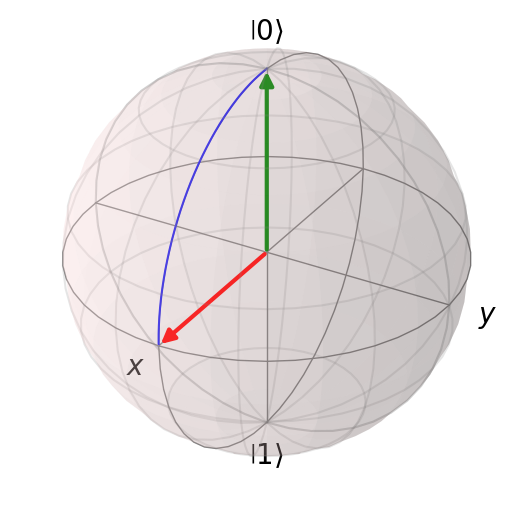

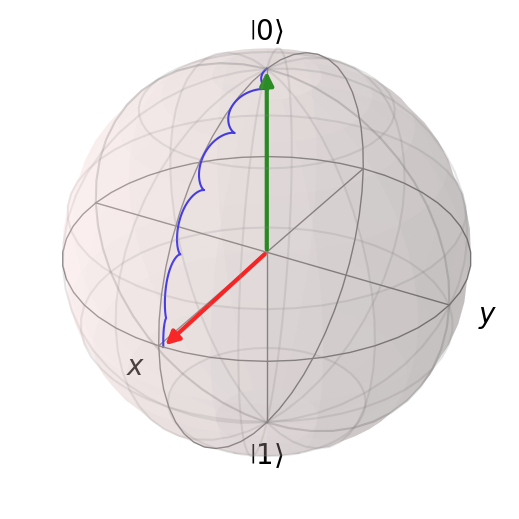

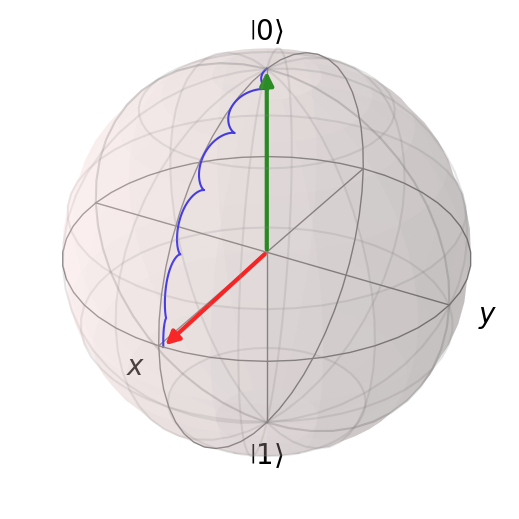

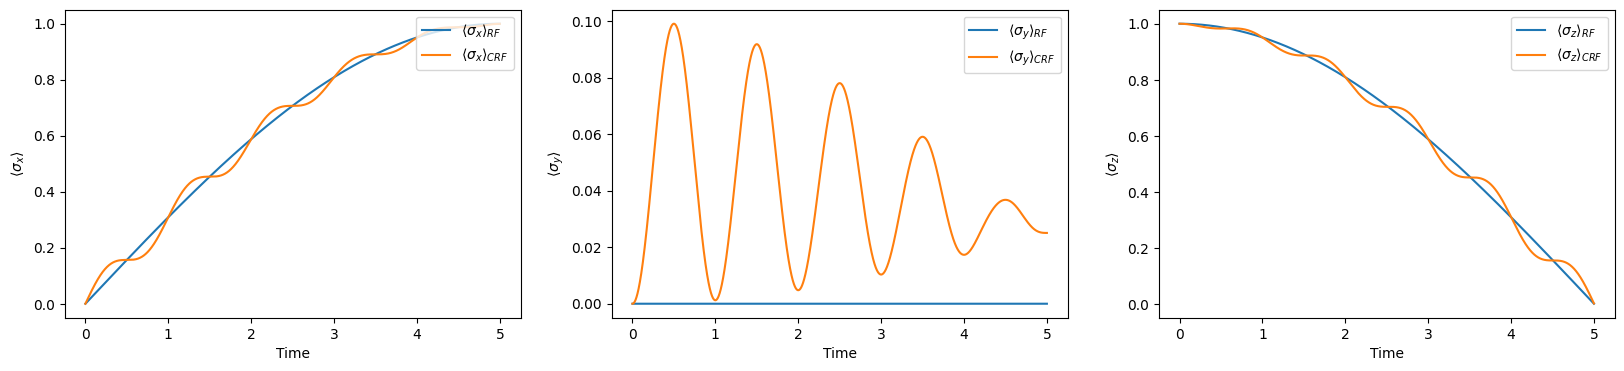

In [143]:
'''Evolve'''
result_rf_sec = QubitSim(psi0, H_RF_sec)(tlist)
result_rf = QubitSim(psi0, H_RF)(tlist)
result_crf = QubitSim(psi0, H_CRF)(tlist)

'''Plot results'''

QubitSim.plot_bloch_sphere(psi0, result_rf_sec).show()
QubitSim.plot_bloch_sphere(psi0, result_rf).show()
QubitSim.plot_bloch_sphere(psi0, result_crf).show()

QubitSim.plot_xyz(
    [result_rf_sec, result_rf, result_crf], 
    ['RF', 'CRF'],
    tlist, 
)
plt.show()

# QubitSim.animate_bloch_sphere(psi0, result.states)

## Lab frames

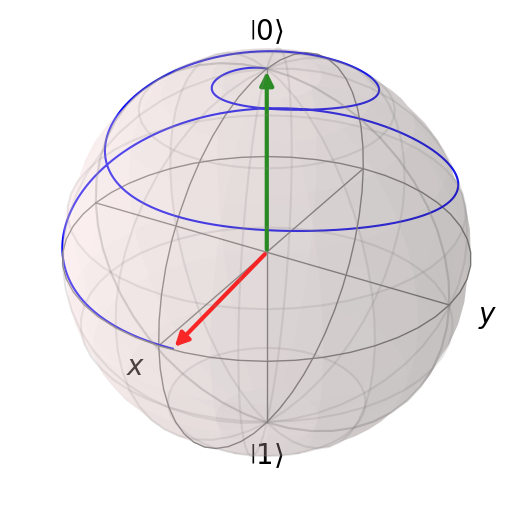

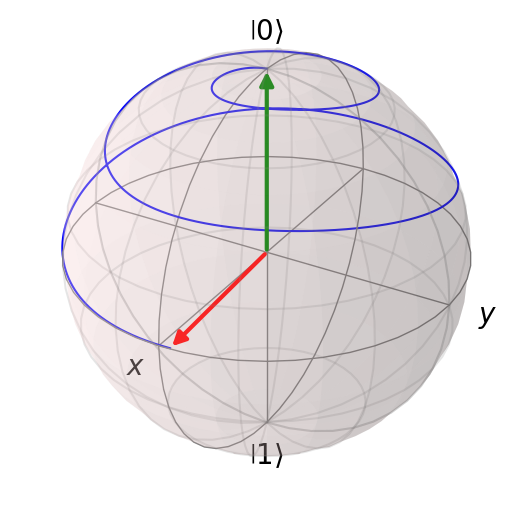

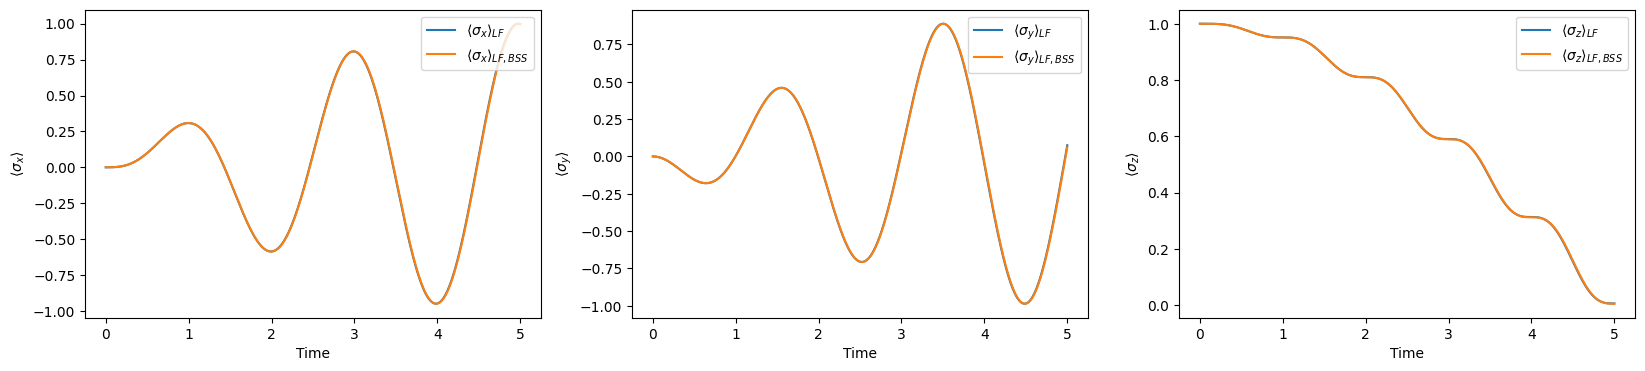

In [138]:
'''Evolve'''
result_lf = QubitSim(psi0, H_LF)(tlist)
result_lf_bss = QubitSim(psi0, H_LF_bss)(tlist)

'''Plot results'''

QubitSim.plot_bloch_sphere(psi0, result_lf).show()
QubitSim.plot_bloch_sphere(psi0, result_lf_bss).show()

QubitSim.plot_xyz(
    [result_lf, result_lf_bss], 
    ['LF', 'LF,BSS'],
    tlist, 
)
plt.show()

# QubitSim.animate_bloch_sphere(psi0, result.states)